In [1]:
from sympy import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def sspuf_A_matrix(n_bit: int, line_len: int):
    """Generate A matrix for SSPUF symbolic model.

    Args:
        n_bit (int): number of bits
        line_len (int): length of line

    Returns:
        Matrix: A matrix
    """
    cc = var('C_c')
    cap, ind = [[None for _ in range(line_len)] for _ in range(n_bit)], [[None for _ in range(line_len)] for _ in range(n_bit)]
    gm_c = [[[None for _ in range(2)] for _ in range(line_len)] for _ in range(n_bit)]
    gm_l = [[[None for _ in range(2)] for _ in range(line_len)] for _ in range(n_bit)]
    sw_bits = [None for _ in range(n_bit)]

    for i in range(n_bit):
        for j in range(line_len):
            cap[i][j] = var(f'C_{i}_{j}')
            ind[i][j] = var(f'L_{i}_{j}')
            gm_c[i][j][0] = var(f'g_C_{i}_{j}_0')
            gm_c[i][j][1] = var(f'g_C_{i}_{j}_1')
            gm_l[i][j][0] = var(f'g_L_{i}_{j}_0')
            gm_l[i][j][1] = var(f'g_L_{i}_{j}_1')
            sw_bits[i] = var(f'b_{i}')
    

    sub_mat_len = 2 * line_len
    def ith_diag_sub_mat(i: int):
        a_i = zeros(sub_mat_len, sub_mat_len)
        for j in range(sub_mat_len - 1):
            if j % 2 == 0:
                c_idx = j // 2
                a_i[j, j + 1] = - gm_c[i][c_idx][1]
                a_i[j + 1, j] = gm_c[i][c_idx][0]
            else:
                l_idx = j // 2 + 1
                a_i[j, j + 1] = - gm_l[i][l_idx][1]
                a_i[j + 1, j] = gm_l[i][l_idx][0]
        return a_i
    
    ai_row_mats = [ith_diag_sub_mat(i) for i in range(n_bit)]
    for i, diag_mat in enumerate(ai_row_mats):
        left_zeros = zeros(sub_mat_len, sub_mat_len * i)
        right_zeros = zeros(sub_mat_len, sub_mat_len * (n_bit - i - 1))
        ai_row_mats[i] = left_zeros.row_join(diag_mat).row_join(right_zeros)
    

    mid_to_branch_row = zeros(1, sub_mat_len * n_bit)
    mid_to_branch_col = zeros(sub_mat_len * n_bit, 1)
    for i in range(n_bit):
        mid_to_branch_row[0, i * sub_mat_len] = -sw_bits[i] * gm_l[i][0][1]
        mid_to_branch_col[i * sub_mat_len, 0] = sw_bits[i] * gm_c[i][0][0]
    
    A_1_to_n = mid_to_branch_row
    for ai_row_mat in ai_row_mats:
        A_1_to_n = A_1_to_n.col_join(ai_row_mat)
    

    A_mat = zeros(1, 1).col_join(mid_to_branch_col).row_join(A_1_to_n)

    LC_mat = zeros(A_mat.shape[0], A_mat.shape[1])
    LC_mat[0, 0] = 1/cc
    for i in range(n_bit):
        for j in range(line_len):
            idx = 1 + i * sub_mat_len + 2 * j
            LC_mat[idx, idx] = 1/cap[i][j]
            LC_mat[idx + 1, idx + 1] = 1/ind[i][j]

    return LC_mat * A_mat, cc, cap, ind, gm_c, gm_l, sw_bits
    
def matrix_exp(A: Matrix, t: Symbol, n_order: int):
    """Approximate matrix exponential with finite Taylor series.

    e^(At) = I + At + (At)^2/2! + (At)^3/3! + ... + (At)^n/n!

    Args:
        A (Matrix): matrix
        t (float): time
        n_order (int): order of Taylor series

    Returns:
        Matrix: matrix exponential
    """
    I = eye(A.shape[0])
    exp_mat = I
    for i in range(1, n_order + 1):
        exp_mat += (A * t)**i / factorial(i)
    return exp_mat

def integral_matrix_exp(A: Matrix, t: Symbol, n_order: int):
    """Approximate integral of matrix exponential with finite Taylor series.

    integral(e^(At)) = t * I + A*t^2/2! + A^2*t^3/3! + ... + A^n*t^(n+1)/(n+1)!

    Args:
        A (Matrix): matrix
        t (float): time
        n_order (int): order of Taylor series

    Returns:
        Matrix: integral of matrix exponential
    """
    I = eye(A.shape[0])
    exp_mat = t * I
    for i in range(1, n_order + 1):
        exp_mat += A**i * t**(i + 1) / factorial(i + 1)
    return exp_mat

def integral_matrix_exp_times_t(A: Matrix, t: Symbol, n_order: int):
    """Approximate integral of matrix exponential times t with finite Taylor series.

    integral(te^(At)) = t^2 * I/2 + A*t^3/3 + A^2*t^4/(2!*4) + ... + A^n*t^(n+2)*(n+1)/(n+2)!

    Args:
        A (Matrix): matrix
        t (float): time
        n_order (int): order of Taylor series
        var (Symbol): variable of integration

    Returns:
        Matrix: integral of matrix exponential times t
    """
    I = eye(A.shape[0])
    exp_mat = t**2 * I / 2
    for i in range(1, n_order + 1):
        exp_mat += A ** i * t ** (i + 2) * (i + 1) / factorial(i + 2)
    return exp_mat

def to_numpy(m: Matrix):
    return np.array(m.tolist()).astype(np.float64)


# Sanity check. A = 11
a = Matrix([[1, 1], [1, 2]])
t = var('t')
display(matrix_exp(a, t, 10))
display(integral_matrix_exp(-a, t, 10))
display(integral_matrix_exp_times_t(-a, t, 10))
display(a ** 2)

Matrix([
[4181*t**10/3628800 + 1597*t**9/362880 + 61*t**8/4032 + 233*t**7/5040 + 89*t**6/720 + 17*t**5/60 + 13*t**4/24 + 5*t**3/6 + t**2 + t + 1,                      451*t**10/241920 + 323*t**9/45360 + 47*t**8/1920 + 377*t**7/5040 + t**6/5 + 11*t**5/24 + 7*t**4/8 + 4*t**3/3 + 3*t**2/2 + t],
[           451*t**10/241920 + 323*t**9/45360 + 47*t**8/1920 + 377*t**7/5040 + t**6/5 + 11*t**5/24 + 7*t**4/8 + 4*t**3/3 + 3*t**2/2 + t, 5473*t**10/1814400 + 4181*t**9/362880 + 1597*t**8/40320 + 61*t**7/504 + 233*t**6/720 + 89*t**5/120 + 17*t**4/12 + 13*t**3/6 + 5*t**2/2 + 2*t + 1]])

Matrix([
[4181*t**11/39916800 - 1597*t**10/3628800 + 61*t**9/36288 - 233*t**8/40320 + 89*t**7/5040 - 17*t**6/360 + 13*t**5/120 - 5*t**4/24 + t**3/3 - t**2/2 + t,                       41*t**11/241920 - 323*t**10/453600 + 47*t**9/17280 - 377*t**8/40320 + t**7/35 - 11*t**6/144 + 7*t**5/40 - t**4/3 + t**3/2 - t**2/2],
[                    41*t**11/241920 - 323*t**10/453600 + 47*t**9/17280 - 377*t**8/40320 + t**7/35 - 11*t**6/144 + 7*t**5/40 - t**4/3 + t**3/2 - t**2/2, 5473*t**11/19958400 - 4181*t**10/3628800 + 1597*t**9/362880 - 61*t**8/4032 + 233*t**7/5040 - 89*t**6/720 + 17*t**5/60 - 13*t**4/24 + 5*t**3/6 - t**2 + t]])

Matrix([
[4181*t**12/43545600 - 1597*t**11/3991680 + 61*t**10/40320 - 233*t**9/45360 + 89*t**8/5760 - 17*t**7/420 + 13*t**6/144 - t**5/6 + t**4/4 - t**3/3 + t**2/2,                         451*t**12/2903040 - 323*t**11/498960 + 47*t**10/19200 - 377*t**9/45360 + t**8/40 - 11*t**7/168 + 7*t**6/48 - 4*t**5/15 + 3*t**4/8 - t**3/3],
[               451*t**12/2903040 - 323*t**11/498960 + 47*t**10/19200 - 377*t**9/45360 + t**8/40 - 11*t**7/168 + 7*t**6/48 - 4*t**5/15 + 3*t**4/8 - t**3/3, 5473*t**12/21772800 - 4181*t**11/3991680 + 1597*t**10/403200 - 61*t**9/4536 + 233*t**8/5760 - 89*t**7/840 + 17*t**6/72 - 13*t**5/30 + 5*t**4/8 - 2*t**3/3 + t**2/2]])

Matrix([
[2, 3],
[3, 5]])

array([[1.23185493e+00, 4.31183479e-01],
       [6.84643270e-05, 1.16320228e+00]])

array([[5.55949821e-01, 1.01607333e-01],
       [1.61334513e-05, 5.39771991e-01]])

array([[1.43814265e-01, 3.43709876e-02],
       [5.45750626e-06, 1.38341747e-01]])

array([[1.23185493e+00, 4.31183479e-01],
       [6.84643270e-05, 1.16320228e+00]])

array([[5.55949821e-01, 1.01607333e-01],
       [1.61334513e-05, 5.39771991e-01]])

array([[1.43814265e-01, 3.43709876e-02],
       [5.45750626e-06, 1.38341747e-01]])

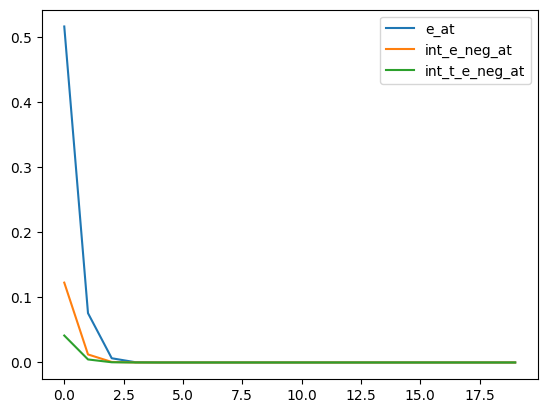

In [7]:
# Debug. Check integral value with invertible matrices.
from scipy.linalg import expm
from numpy.linalg import inv, matrix_power

def numerical_expm_int(A, t0, t1):
    return inv(A) @ (expm(A * t1) - expm(A * t0))

def numerical_expm_t_int(A, t0, t1):
    return - matrix_power(inv(A), 2) @ (expm(A * t1) - expm(A * t0)) + inv(A) @ (expm(A * t1) * t1 - expm(A * t0) * t0)

np.random.seed(1)
a = np.random.rand(2, 2)
t0, t1 = 0, 0.5
e_at = expm(a * t1)
int_e_neg_at = numerical_expm_int(a, t0, t1)
int_t_e_neg_at = numerical_expm_t_int(a, t0, t1)
display(e_at)
display(int_e_neg_at)
display(int_t_e_neg_at)
a = Matrix(a)
errs = [[], [], []]
for n_order in range(20):
    approx_e_at = to_numpy(matrix_exp(a, t1, n_order))
    approx_int_e_neg_at = to_numpy(integral_matrix_exp(a, t1, n_order) - integral_matrix_exp(a, t0, n_order))
    approx_int_t_e_neg_at = to_numpy(integral_matrix_exp_times_t(a, t1, n_order) - integral_matrix_exp_times_t(a, t0, n_order))
    errs[0].append(np.linalg.norm(e_at - approx_e_at))
    errs[1].append(np.linalg.norm(int_e_neg_at - approx_int_e_neg_at))
    errs[2].append(np.linalg.norm(int_t_e_neg_at - approx_int_t_e_neg_at))

display(approx_e_at)
display(approx_int_e_neg_at)
display(approx_int_t_e_neg_at)
plt.figure()
plt.plot(errs[0], label='e_at')
plt.plot(errs[1], label='int_e_neg_at')
plt.plot(errs[2], label='int_t_e_neg_at')
plt.legend()
plt.show()

In [8]:
def flatten_list(x):
    while isinstance(x[0], list):
        x = sum(x, [])
    return x

A_mat, cc, cap, ind, gm_c, gm_l, sw_bits = sspuf_A_matrix(2, 2)
gm_c_flat, gm_l_flat = flatten_list(gm_c), flatten_list(gm_l)
A_numerical = A_mat.subs({gm: 1 for gm in gm_c_flat + gm_l_flat})
for power in range(4):
    display(A_numerical ** power)

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 1]])

Matrix([
[        0, -b_0/C_c,        0,        0,        0, -b_1/C_c,        0,        0,        0],
[b_0/C_0_0,        0, -1/C_0_0,        0,        0,        0,        0,        0,        0],
[        0,  1/L_0_0,        0, -1/L_0_0,        0,        0,        0,        0,        0],
[        0,        0,  1/C_0_1,        0, -1/C_0_1,        0,        0,        0,        0],
[        0,        0,        0,  1/L_0_1,        0,        0,        0,        0,        0],
[b_1/C_1_0,        0,        0,        0,        0,        0, -1/C_1_0,        0,        0],
[        0,        0,        0,        0,        0,  1/L_1_0,        0, -1/L_1_0,        0],
[        0,        0,        0,        0,        0,        0,  1/C_1_1,        0, -1/C_1_1],
[        0,        0,        0,        0,        0,        0,        0,  1/L_1_1,        0]])

Matrix([
[(-C_0_0*b_1**2 - C_1_0*b_0**2)/(C_0_0*C_1_0*C_c),                                       0,                    b_0/(C_0_0*C_c),                                  0,                0,                                       0,                    b_1/(C_1_0*C_c),                                  0,                0],
[                                               0, (-C_c - L_0_0*b_0**2)/(C_0_0*C_c*L_0_0),                                  0,                    1/(C_0_0*L_0_0),                0,                    -b_0*b_1/(C_0_0*C_c),                                  0,                                  0,                0],
[                               b_0/(C_0_0*L_0_0),                                       0, -1/(C_0_1*L_0_0) - 1/(C_0_0*L_0_0),                                  0,  1/(C_0_1*L_0_0),                                       0,                                  0,                                  0,                0],
[                                               0

Matrix([
[                                                                              0, b_0*b_1**2/(C_1_0*C_c**2) - b_0*(-C_c - L_0_0*b_0**2)/(C_0_0*C_c**2*L_0_0),                                                                   0,                                           -b_0/(C_0_0*C_c*L_0_0),                                       0, -b_1*(-C_c - L_1_0*b_1**2)/(C_1_0*C_c**2*L_1_0) + b_0**2*b_1/(C_0_0*C_c**2),                                                                   0,                                           -b_1/(C_1_0*C_c*L_1_0),                                       0],
[-b_0/(C_0_0**2*L_0_0) + b_0*(-C_0_0*b_1**2 - C_1_0*b_0**2)/(C_0_0**2*C_1_0*C_c),                                                                          0, -(-1/(C_0_1*L_0_0) - 1/(C_0_0*L_0_0))/C_0_0 + b_0**2/(C_0_0**2*C_c),                                                                0,                  -1/(C_0_0*C_0_1*L_0_0),                                                                      

In [9]:

t = var('t')
tau = var('tau')

"""Pulse forcing function.

u(t) = {
    0, t < 0
    h/t1 * t, 0 <= t < t1
    h, t1 <= t < t2
    h/(t2 - t3) * (t - t3), t2 <= t < t3
    0, t >= t3
}
"""
pulse_amplitude = var('h')
pulse_rise_time = var('t_r')
pulse_hold_time = var('t_h')
pulse_fall_time = var('t_f')
t1 = pulse_rise_time
t2 = t1 + pulse_hold_time
t3 = t2 + pulse_fall_time

def sspuf_symbolic(n_bit: int, line_len: int, n_order: int=10):
    """Generate symbolic SSPUF model.

    Args:
        n_bit (int): number of bits
        line_len (int): length of line
        t (Symbol): time
        n_order (int): order of Taylor series for approximation

    Returns:
        Matrix: symbolic SSPUF model
    """
    A_mat, cc, cap, ind, gm_c, gm_l, sw_bits = sspuf_A_matrix(n_bit, line_len)
    B_mat, C_mat, D_mat = zeros(A_mat.shape[0], 1), zeros(1, A_mat.shape[0]), zeros(1, 1)
    B_mat[0, 0] = 1/cc
    C_mat[0, 0] = 1
    exp_mat = matrix_exp(A_mat, t, n_order) # E^(At)
    int_exp_mat = integral_matrix_exp(-A_mat, tau, n_order) # integral(E^(-At))
    int_exp_t_mat = integral_matrix_exp_times_t(-A_mat, tau, n_order) # integral(t * E^(-At))

    rise_integral = pulse_amplitude / t1 * int_exp_t_mat.subs(tau, t1) * B_mat
    hold_integral = pulse_amplitude * (int_exp_mat.subs(tau, t2) - int_exp_mat.subs(tau, t1)) * B_mat
    fall_integral = pulse_amplitude / (t2 - t3) * (int_exp_t_mat.subs(tau, t3) - int_exp_t_mat.subs(tau, t2) -
                                                   t3 * (int_exp_mat.subs(tau, t3) - int_exp_mat.subs(tau, t2))) * B_mat
    lds = (A_mat, B_mat, C_mat, D_mat)
    sol = C_mat * exp_mat * (rise_integral + hold_integral + fall_integral)

    return lds, sol, cc, cap, ind, gm_c, gm_l, sw_bits

In [30]:
lds, sol, cc, cap, ind, gm_c, gm_l, sw_bits = sspuf_symbolic(1, 1, 50)

In [31]:
cap_flat = flatten_list(cap)
ind_flat = flatten_list(ind)
gm_c_flat = flatten_list(gm_c)
gm_l_flat = flatten_list(gm_l)
gm_sub = {gm: 1 for gm in gm_c_flat + gm_l_flat}
lc_sub = {element: 1e-9 for element in cap_flat + ind_flat}
pulse_sub = {
    pulse_amplitude: 1,
    pulse_rise_time: 0.5e-9,
    pulse_hold_time: 1e-9,
    pulse_fall_time: 0.5e-9,
}
nominal_val = gm_sub | lc_sub | pulse_sub | {cc: 1e-9}


In [32]:
sol_nominal = sol.subs(nominal_val)[0, 0]

display(sol_nominal)
sol_nominal_1 = sol_nominal.subs({b: 1 for b in sw_bits})
display(sol_nominal_1)

(-1.66666666666667e+35*b_0*t*(-1.0e-9*b_0**2*t**2 - 1.0e-9*t**2) - 198412.698412698*b_0*t*(-1.0e+36*b_0*t*(-1.0e-9*b_0**2*t**2 - 1.0e-9*t**2)*(-1.0e+27*b_0**3*t**3 - 1.0e+27*b_0*t**3) + 1.0e+36*t*(-1.0e-9*b_0**2*t**2 - 1.0e-9*t**2)*(1.0e+27*b_0**2*t**3 + 1.0e+27*t**3)) - 1.64397470831657e+234*b_0*t*(-b_0*t*(-1.0e-9*b_0**2*t**2 - 1.0e-9*t**2)*(-1.0e+27*b_0**3*t**3 - 1.0e+27*b_0*t**3) + t*(-1.0e-9*b_0**2*t**2 - 1.0e-9*t**2)*(1.0e+27*b_0**2*t**3 + 1.0e+27*t**3))**8 - 6.44695028438446e+127*b_0*t*(-b_0*t*(-1.0e-9*b_0**2*t**2 - 1.0e-9*t**2)*(-1.0e+27*b_0**3*t**3 - 1.0e+27*b_0*t**3) + t*(-1.0e-9*b_0**2*t**2 - 1.0e-9*t**2)*(1.0e+27*b_0**2*t**3 + 1.0e+27*t**3))**4 - 1.60590438368216e+71*b_0*t*(-b_0*t*(-1.0e-9*b_0**2*t**2 - 1.0e-9*t**2)*(-1.0e+27*b_0**3*t**3 - 1.0e+27*b_0*t**3) + t*(-1.0e-9*b_0**2*t**2 - 1.0e-9*t**2)*(1.0e+27*b_0**2*t**3 + 1.0e+27*t**3))**2 - 25.0521083854417*b_0*t*(-1.0e+63*b_0*t*(1000000000.0*b_0*t*(1.0e+36*b_0**4*t**4 + 1.0e+36*b_0**2*t**4) - 1000000000.0*t*(-1.0e+36*b_0**3*t

-1.03967136241642e+392*t**50 + 2.32829131303767e+385*t**49 + 1.27359741896012e+377*t**48 - 2.7380705841323e+370*t**47 - 1.43661788858701e+362*t**46 + 2.95985430144702e+355*t**45 + 1.48689951468756e+347*t**44 - 2.93025575843255e+340*t**43 - 1.40660694089443e+332*t**42 + 2.64602094986459e+325*t**41 + 1.21108857611011e+317*t**40 - 2.16973717888897e+310*t**39 - 9.44649089365883e+301*t**38 + 1.60777524955672e+295*t**37 + 6.64088309824216e+286*t**36 - 1.07077831620478e+280*t**35 - 4.18375635189256e+271*t**34 + 6.37113098141843e+264*t**33 + 2.34708731341172e+256*t**32 - 3.36395715818893e+249*t**31 - 1.16415530745222e+241*t**30 + 1.56424007855785e+234*t**29 + 5.06407558741714e+225*t**28 - 6.35081471894488e+218*t**27 - 1.91422057204368e+210*t**26 + 2.22913596634965e+203*t**25 + 6.22121685914196e+194*t**24 - 6.68740789904897e+187*t**23 - 1.71705585312318e+179*t**22 + 1.69191419845939e+172*t**21 + 3.96639902071455e+163*t**20 - 3.55301981676472e+156*t**19 - 7.53615813935764e+147*t**18 + 6.07566388

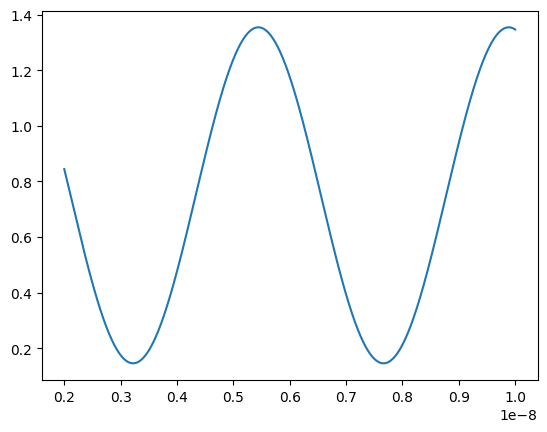

In [33]:

traj = []
time_points = np.linspace(2e-9, 10e-9, 1000)

for time in time_points:
    traj.append(sol_nominal_1.subs({t: time}))

plt.plot(time_points, traj)

In [42]:
from scipy.signal import lsim
from spec import pulse


a, b, c, d = lds
a = a.subs(nominal_val).subs({b: 1 for b in sw_bits})
b = b.subs(nominal_val)
display(a, b, c, d)
a, b, c, d = to_numpy(a), to_numpy(b), to_numpy(c), to_numpy(d)
input_time_points = np.linspace(0, 50e-9, 1000)
u = [pulse(p, amplitude=1, delay=0, rise_time=0.5e-9, fall_time=0.5e-9, pulse_width=1e-9) 
     for p in input_time_points]

tout, yout, xout = lsim((a, b, c, d), U=u, T=input_time_points)

Matrix([
[           0, -1000000000.0,             0],
[1000000000.0,             0, -1000000000.0],
[           0,  1000000000.0,             0]])

Matrix([
[1000000000.0],
[           0],
[           0]])

Matrix([[1, 0, 0]])

Matrix([[0]])

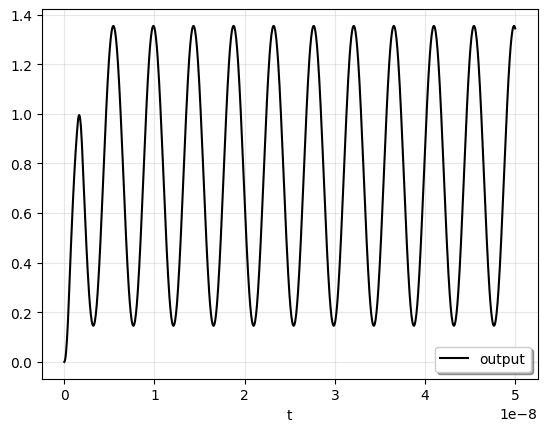

In [43]:
# plt.plot(time_points, u, 'r', alpha=0.5, linewidth=1, label='input')
plt.plot(tout, yout, 'k', linewidth=1.5, label='output')
plt.legend(loc='best', shadow=True, framealpha=1)
plt.grid(alpha=0.3)
plt.xlabel('t')
plt.show()


In [37]:
print(latex(A_mat))

\left[\begin{matrix}0 & - \frac{b_{0} g_{L 0 0 1}}{C_{c}} & 0 & 0 & 0 & - \frac{b_{1} g_{L 1 0 1}}{C_{c}} & 0 & 0 & 0\\\frac{b_{0} g_{C 0 0 0}}{C_{0 0}} & 0 & - \frac{g_{C 0 0 1}}{C_{0 0}} & 0 & 0 & 0 & 0 & 0 & 0\\0 & \frac{g_{C 0 0 0}}{L_{0 0}} & 0 & - \frac{g_{L 0 1 1}}{L_{0 0}} & 0 & 0 & 0 & 0 & 0\\0 & 0 & \frac{g_{L 0 1 0}}{C_{0 1}} & 0 & - \frac{g_{C 0 1 1}}{C_{0 1}} & 0 & 0 & 0 & 0\\0 & 0 & 0 & \frac{g_{C 0 1 0}}{L_{0 1}} & 0 & 0 & 0 & 0 & 0\\\frac{b_{1} g_{C 1 0 0}}{C_{1 0}} & 0 & 0 & 0 & 0 & 0 & - \frac{g_{C 1 0 1}}{C_{1 0}} & 0 & 0\\0 & 0 & 0 & 0 & 0 & \frac{g_{C 1 0 0}}{L_{1 0}} & 0 & - \frac{g_{L 1 1 1}}{L_{1 0}} & 0\\0 & 0 & 0 & 0 & 0 & 0 & \frac{g_{L 1 1 0}}{C_{1 1}} & 0 & - \frac{g_{C 1 1 1}}{C_{1 1}}\\0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac{g_{C 1 1 0}}{L_{1 1}} & 0\end{matrix}\right]
